# Financial Econometrics Project
Author: Joonas Kauto
SCIPER: 349328

In [1]:
# External libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow
from keras import models
from keras import layers
from sklearn.preprocessing import StandardScaler  


## Data extraction and preparation

In [2]:

def read_file(name,datafolder):
    """
    Simple file reading function, might save some lines here and there
    """
    MASTER_DATA_FOLDER = "jpx-tokyo-stock-exchange-prediction"
    data_folder = os.path.join(os.getcwd(), MASTER_DATA_FOLDER)
    folder = os.path.join(data_folder, datafolder)
    path = os.path.join(folder,name)
    print(path)

    df = pd.read_csv(path)
    return df

In [3]:
# Let's bring in the data!
TRAIN_DATA = "train_files"
# TEST_DATA = "example_test_files"
df_load = read_file('stock_prices.csv', TRAIN_DATA)

c:\Users\joona\koodausta\EPFL\Fin_Econometrics_EPFL\project\jpx-tokyo-stock-exchange-prediction\train_files\stock_prices.csv


In [4]:

# Let's copy it to different dataframe -  if we have problems we dont need to load the data again from the source.
df = df_load.copy()


In [5]:
# Make the date column to datetime.
df['Date'] = pd.to_datetime(df['Date'])

# Filter out companies who are going to be delisted during the timeperiod:
delisted_companies = df[df['SupervisionFlag'] == True]['SecuritiesCode'].unique()
df = df[~df['SecuritiesCode'].isin(delisted_companies)]

In [6]:
columns_to_keep = ['RowId',	'Date',	'SecuritiesCode', 'Open', 'High', 'Low', 'Close', 'Volume']
df = df[columns_to_keep]
df

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800
...,...,...,...,...,...,...,...,...
2332526,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200
2332527,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900
2332528,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200
2332529,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500


In [7]:
# Number of companies at this point!
len_check_1 = len(df.SecuritiesCode.unique())
print("We have", len_check_1, "Different securities!")

We have 1985 Different securities!


In [8]:
# Now lets develop features into our training data
# As you can see, these are derived from past price data only.

def feature_generation(df):

    """
    PS = Has the stock price increased or decreased
    PSY12 = Psychological line for 12 days (DUP12 / 12) * 100
    DU12 = number of dates when price has gone up in 12 days before forecasting date
    
    MA5 = 5 days moving average
    MA10 = 10 days moving average
    MA20 = 20 days moving average

    OS6 = 6 day return
    OS12 = 12 day return

    MTM6 = difference between 6 day closing value
    MTM12 = difference between 12 day closing value

    ASY5 = average stock yield of 5 days before the forecasting day
    ASY4 = average stock yield of 4 days before the forecasting day
    ASY3 = average stock yield of 3 days before the forecasting day
    ASY2 = average stock yield of 2 days before the forecasting day
    ASY1 = average stock yield of 1 days before the forecasting day

    CL3 = Closing price of 3 days before forecasting date
    CL2 = Closing price of 3 days before forecasting date
    CL1 = Closing price of 3 days before forecasting date


    VOL20_price = Closing price's standard deviation from 20 days

    df_i['BOL_UPPER'] = (df_i['Close'] - (df_i['MA20'] + df_i['VOL20_price']*2)) / (df_i['MA20'] + df_i['VOL20_price']*2)
    df_i['BOL_LOWER'] = (df_i['Close'] - (df_i['MA20'] - df_i['VOL20_price']*2)) / (df_i['MA20'] - df_i['VOL20_price']*2)
    
    """
    # The growth during one trading day
    df['DayReturn'] = (df['Close'] - df['Open'])/df['Open']
    
    def psychological_effect(r):
        if r >= 0:
            return 1
        else:
            return 0
        
    df['PS'] = df.apply(lambda x: psychological_effect(x['DayReturn']),axis=1)

    df_temp = pd.DataFrame()

    check_time = len(df.SecuritiesCode.unique())
    timer = 0
    for security in df.SecuritiesCode.unique():
        
        # Let's look at the data security at time
        df_i = df[df['SecuritiesCode'] == security]
        df_i = df_i.sort_values(by="Date")

        # moving averages
        df_i['MA5'] = df_i['Close'].rolling(5).mean()
        df_i['MA10'] = df_i['Close'].rolling(10).mean()
        df_i['MA20'] = df_i['Close'].rolling(20).mean()

        # Bias

        df_i['BIAS5'] = (df_i['Close'] - df_i['MA5']) / df_i['MA5']


        # The psychology factor
        df_i['PS12'] = df_i['PS'].rolling(12).mean()

        # Closing values, used in calculations
        closing_values = df_i['Close'].values

        # Target variable is the (Close price (t+1) - Close price(t)) / Close price (t)
        target = (closing_values[1:] - closing_values[:-1]) / closing_values[:-1]
        target = np.append(target, np.nan)

        df_i['TargetVariable'] = target

        # Oscillation values AKA differences between prices
        helper = np.array([np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
        big_helper = np.array([np.nan,np.nan,np.nan,np.nan,np.nan,np.nan, np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
        OSC6 = closing_values[6:] / closing_values[:-6]
        OSC12 = closing_values[12:] / closing_values[:-12]
        OSC6 = np.append(helper, OSC6)
        OSC12 = np.append(big_helper, OSC12)
        df_i['OSC6'] = OSC6
        df_i['OSC12'] = OSC12


        # Momentum
        MTM6 = closing_values[6:] - closing_values[:-6]
        MTM12 = closing_values[12:] - closing_values[:-12]

        MTM6 = np.append(helper, MTM6)
        MTM12 = np.append(big_helper, MTM12)
        df_i['MTM6'] = MTM6
        df_i['MTM12'] = MTM12

        # Yields
        ASY1 = (closing_values[1:] - closing_values[:-1]) / closing_values[:-1]
        ASY1 = np.insert(ASY1, 0, np.nan)
        df_i['ASY1'] = ASY1
        df_i['ASY5'] = df_i['ASY1'].rolling(5).mean()
        df_i['ASY4'] = df_i['ASY1'].rolling(4).mean()
        df_i['ASY3'] = df_i['ASY1'].rolling(3).mean()
        df_i['ASY2'] = df_i['ASY1'].rolling(2).mean()

        # Volatilities
        df_i['Vol5'] = df_i['ASY1'].rolling(5).std()
        df_i['Vol10'] = df_i['ASY1'].rolling(10).std()
        df_i['Vol20'] = df_i['ASY1'].rolling(20).std()

        # Bollinger bands
        df_i['VOL20_price'] = df_i['Close'].rolling(20).std()

        df_i['BOL_UPPER'] = (df_i['Close'] - (df_i['MA20'] + df_i['VOL20_price']*2)) / (df_i['MA20'] + df_i['VOL20_price']*2)
        df_i['BOL_LOWER'] = (df_i['Close'] - (df_i['MA20'] - df_i['VOL20_price']*2)) / (df_i['MA20'] - df_i['VOL20_price']*2)

        if df_temp.empty:
            df_temp = df_i
        else:
            df_temp = df_temp.append(df_i, ignore_index=True)
    
    return df_temp


In [9]:
df_features = feature_generation(df)


In [10]:
# Number of companies at this point!
len_check_2 = len(df_features.SecuritiesCode.unique())
df_filled = df_features.dropna() # Dropnans
len_check_3 = len(df_filled.SecuritiesCode.unique())
print("This should be zero:", len_check_2- len_check_3)

This should be zero: 0


In [11]:
# Let's decide the date split
N_dates = len(df_filled.Date.unique())
n_after_test = int(np.floor(1161 * 0.7))
dates_ = df_filled.Date.unique()
print("After the day index of", n_after_test, "which is", dates_[int(n_after_test)], " is the test data.")

After the day index of 812 which is 2020-06-03T00:00:00.000000000  is the test data.


In [29]:
dates_[0]


numpy.datetime64('2017-02-02T00:00:00.000000000')

In [12]:
df_ = df_filled.copy()
df_ = df_.sort_values(by=['Date'])
df_train = df_.head(n_after_test*len_check_3)
df_test = df_.tail((len(dates_) - n_after_test)*len_check_3)



# Checking the data!

In [13]:
df_grouped = df_train.groupby(['Date']).mean()

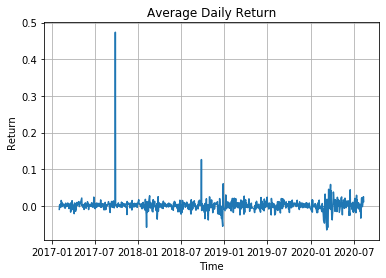

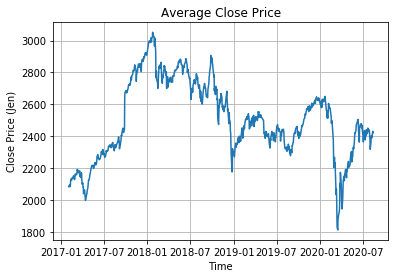

In [14]:

fig, ax = plt.subplots()
ax.plot(df_grouped.index, df_grouped['ASY1'])

ax.set(xlabel='Time', ylabel='Return',
       title='Average Daily Return')
ax.grid()
plt.show()

fig, ax = plt.subplots()
ax.plot(df_grouped.index, df_grouped['Close'])

ax.set(xlabel='Time', ylabel='Close Price (Jen)',
       title='Average Close Price')
ax.grid()
plt.show()



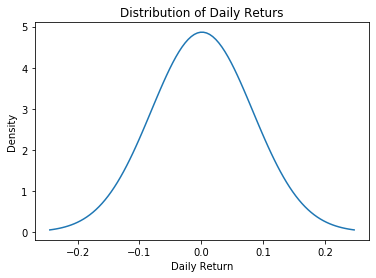

In [15]:
import scipy.stats as stats
import math

fig, ax = plt.subplots()
mu = df_train['ASY1'].mean()
sigma =  df_train['ASY1'].std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax.plot(x, stats.norm.pdf(x, mu, sigma))
ax.set(xlabel='Daily Return', ylabel='Density',
       title='Distribution of Daily Returs')
plt.show()



In [16]:
# From here on grouped by security
df__ = df_train[['Date', 'SecuritiesCode', 'Close', 'ASY1']]
df_security_grouped_std = df__.groupby(['SecuritiesCode']).std()
df_security_grouped_mean = df__.groupby(['SecuritiesCode']).mean()

In [34]:
df_security_grouped_std.mean()

Close    665.075370
ASY1       0.045474
dtype: float64

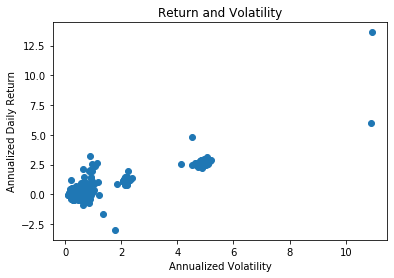

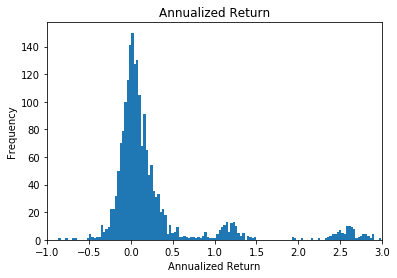

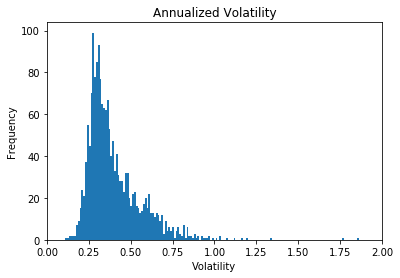

In [17]:
vols = df_security_grouped_std['ASY1']*np.sqrt(252)
means_returns = df_security_grouped_mean['ASY1']*252
fig, ax = plt.subplots()
ax.scatter(vols,  means_returns)
ax.set(xlabel='Annualized Volatility', ylabel='Annualized Daily Return',
       title='Return and Volatility')
plt.show()

fig, ax = plt.subplots()
ax.hist(means_returns, bins=1000)
ax.set(xlabel='Annualized Return', ylabel='Frequency',
       title='Annualized Return')
plt.xlim(-1, 3)
plt.show()

fig, ax = plt.subplots()
ax.hist(vols, bins=1000)
ax.set(xlabel='Volatility', ylabel='Frequency',
       title='Annualized Volatility')
plt.xlim(0, 2)
plt.show()


In [18]:
print("Mean one day return:", df_train['ASY1'].mean())


Mean one day return: 0.001036722283111171


### standardizing our features


In [19]:
feature_columns = [ 'Open', 'High', 'Low', 'Close',
       'Volume', 'DayReturn', 'PS', 'MA5', 'MA10', 'MA20', 'BIAS5',
       'PS12', 'OSC6', 'OSC12', 'MTM6', 'MTM12', 'ASY1',
       'ASY5', 'ASY4', 'ASY3', 'ASY2', 'Vol5', 'Vol10', 'Vol20', 'VOL20_price',
       'BOL_UPPER', 'BOL_LOWER']

# Split the data and filter out useless columns.
test = df_test[feature_columns]
train = df_train[feature_columns]
Y_train = df_train[['TargetVariable']]
Y_test = df_test[['TargetVariable']]

In [20]:
# Lets standardize our parameters.
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  

# Don't cheat - fit only on training data
scaler.fit(train.dropna())  

X_train = scaler.transform(train.dropna())  

# apply same transformation to test data
X_test = scaler.transform(test)  

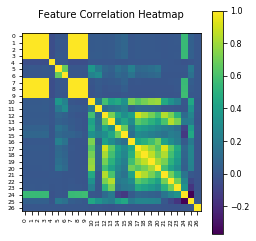

In [21]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=6, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=6)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=8)
    plt.title("Feature Correlation Heatmap", fontsize=10)
    plt.show()


show_heatmap(pd.DataFrame(X_train))

# The actual model

In [22]:
# A function used for measuring errors

def check_error_rates(Y_pred, Y_test):
    mae = tensorflow.keras.losses.MeanAbsoluteError()
    mse = tensorflow.keras.losses.MeanSquaredError()
    mae_result = mae(Y_test, Y_pred).numpy()

    mse_result = mse(Y_test, Y_pred).numpy()
    
    return(mse_result, mae_result)


In [40]:
model = models.Sequential()
model.add(layers.Dense(27, input_dim=27))
model.add(layers.Dense(14, activation='relu'))
model.add(layers.Dense(7, activation='relu'))
model.add(layers.Dense(1))
# Compile model
model.compile(optimizer=tensorflow.keras.optimizers.SGD(learning_rate=0.0001), loss='mean_squared_error')
# Fit the mode
history= model.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=10, batch_size=19, verbose=True)

Epoch 1/10
84833/84833 [==============================] - 228s 3ms/step - loss: 0.0279 - val_loss: 0.0023
Epoch 2/10
84833/84833 [==============================] - 244s 3ms/step - loss: 0.0073 - val_loss: 0.0013
Epoch 3/10
84833/84833 [==============================] - 245s 3ms/step - loss: 0.0069 - val_loss: 0.0012
Epoch 4/10
84833/84833 [==============================] - 255s 3ms/step - loss: 0.0069 - val_loss: 0.0011
Epoch 5/10
84833/84833 [==============================] - 198s 2ms/step - loss: 0.0068 - val_loss: 0.0011
Epoch 6/10
84833/84833 [==============================] - 220s 3ms/step - loss: 0.0068 - val_loss: 0.0011
Epoch 7/10
84833/84833 [==============================] - 293s 3ms/step - loss: 0.0068 - val_loss: 0.0011
Epoch 8/10
84833/84833 [==============================] - 171s 2ms/step - loss: 0.0068 - val_loss: 0.0011
Epoch 9/10
84833/84833 [==============================] - 196s 2ms/step - loss: 0.0068 - val_loss: 0.0011
Epoch 10/10
84833/84833 [=====================

In [41]:
Y_pred = model.predict(X_test)
mse_main, mae_main = check_error_rates(Y_pred, Y_test)
print("MSE:", mse_main, "MAE:", mae_main)

MSE: 0.00107337 MAE: 0.01645612


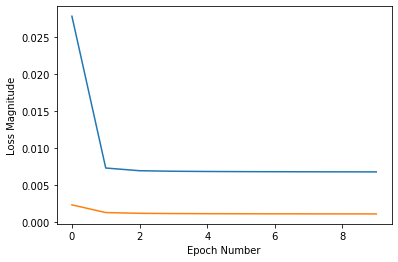

In [42]:
plt.xlabel('Epoch Number')
plt.ylabel("Loss Magnitude")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

This company's MSE: 0.0010796657


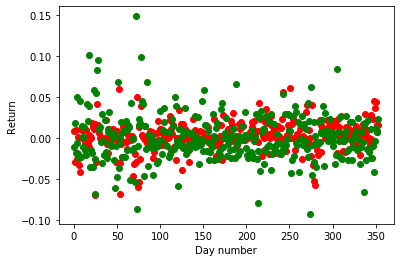

In [38]:
# Let's plot of a randomly selected security's price development for the test period and our prediction of the price development.
sec = df_test.SecuritiesCode.unique()[23]
df_plot_X = df_test[df_test['SecuritiesCode'] == sec][feature_columns]
Y_test_plot = df_test[df_test['SecuritiesCode'] == sec]['TargetVariable']
X_plot = scaler.transform(df_plot_X) 

Y_pred_plot = model.predict(X_plot)
mse = tensorflow.keras.losses.MeanSquaredError()
print("This company's MSE:", mse(Y_test_plot.values, Y_pred_plot).numpy())
# Plot the time period
plt.plot(Y_pred_plot,linestyle="",marker="o", color="r")
plt.plot(Y_test_plot.values,linestyle="",marker="o", color="g")
plt.xlabel('Day number')
plt.ylabel("Return")
plt.show()

## Comparison models

In [ ]:
# First comparison model:
# THe same model with higher batch size and Tanh
model_comparison_1 = models.Sequential()
model_comparison_1.add(layers.Dense(27, input_dim=27))
model_comparison_1.add(layers.Dense(200, activation='tanh'))
model_comparison_1.add(layers.Dense(200, activation='tanh'))
model_comparison_1.add(layers.Dense(1))
# Compile model
model_comparison_1.compile(optimizer=tensorflow.keras.optimizers.SGD(learning_rate=0.0001), loss='mean_squared_error')
# Fit the model
history_comparison_1 = model_comparison_1.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=5, batch_size=19, verbose=True)

Epoch 1/5
84833/84833 [==============================] - 177s 2ms/step - loss: 0.0089 - val_loss: 0.0016
Epoch 2/5
84833/84833 [==============================] - 209s 2ms/step - loss: 0.0072 - val_loss: 0.0014
Epoch 3/5
84833/84833 [==============================] - 221s 3ms/step - loss: 0.0070 - val_loss: 0.0013
Epoch 4/5
84833/84833 [==============================] - 188s 2ms/step - loss: 0.0070 - val_loss: 0.0013
Epoch 5/5
84833/84833 [==============================] - 173s 2ms/step - loss: 0.0069 - val_loss: 0.0013


In [ ]:
Y_pred_c1 = model_comparison_1.predict(X_test)
mse_c1, mae_c1 = check_error_rates(Y_pred_c1, Y_test)
print("MSE:", mse_c1, "MAE:", mae_c1)

MSE: 0.0012627472 MAE: 0.018336283


In [ ]:
# High batch size
model_comparison_x = models.Sequential()
model_comparison_x.add(layers.Dense(27, input_dim=27))
model_comparison_x.add(layers.Dense(200, activation='relu'))
model_comparison_x.add(layers.Dense(200, activation='relu'))
model_comparison_x.add(layers.Dense(1))
# Compile model
model_comparison_x.compile(optimizer=tensorflow.keras.optimizers.SGD(learning_rate=0.0001), loss='mean_squared_error')
# Fit the model
history_comparison_x = model_comparison_x.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=5, batch_size=19, verbose=True)

Epoch 1/5
84833/84833 [==============================] - 165s 2ms/step - loss: 0.0122 - val_loss: 0.0023
Epoch 2/5
84833/84833 [==============================] - 164s 2ms/step - loss: 0.0079 - val_loss: 0.0019
Epoch 3/5
84833/84833 [==============================] - 163s 2ms/step - loss: 0.0074 - val_loss: 0.0017
Epoch 4/5
84833/84833 [==============================] - 165s 2ms/step - loss: 0.0073 - val_loss: 0.0016
Epoch 5/5
84833/84833 [==============================] - 167s 2ms/step - loss: 0.0072 - val_loss: 0.0015


In [ ]:
Y_pred_cx = model_comparison_x.predict(X_test)
mse_cx, mae_cx = check_error_rates(Y_pred_cx, Y_test)
print("MSE:", mse_cx, "MAE:", mae_cx)

MSE: 0.0015439045 MAE: 0.022613522


In [ ]:
# Model with only tanh as a activation function
model_comparison_2 = models.Sequential()
model_comparison_2.add(layers.Dense(27, input_dim=27))
model_comparison_2.add(layers.Dense(14, activation='tanh'))
model_comparison_2.add(layers.Dense(7, activation='tanh'))
model_comparison_2.add(layers.Dense(1))
# Compile model
model_comparison_2.compile(optimizer=tensorflow.keras.optimizers.SGD(learning_rate=0.0001), loss='mean_squared_error')
# Fit the model
history_comparison_2 = model_comparison_2.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=10, batch_size=252, verbose=True)

Epoch 1/10
6397/6397 [==============================] - 9s 1ms/step - loss: 0.0592 - val_loss: 0.0194
Epoch 2/10
6397/6397 [==============================] - 9s 1ms/step - loss: 0.0226 - val_loss: 0.0130
Epoch 3/10
6397/6397 [==============================] - 10s 1ms/step - loss: 0.0182 - val_loss: 0.0104
Epoch 4/10
6397/6397 [==============================] - 10s 1ms/step - loss: 0.0161 - val_loss: 0.0089
Epoch 5/10
6397/6397 [==============================] - 10s 1ms/step - loss: 0.0148 - val_loss: 0.0078
Epoch 6/10
6397/6397 [==============================] - 10s 1ms/step - loss: 0.0138 - val_loss: 0.0070
Epoch 7/10
6397/6397 [==============================] - 10s 2ms/step - loss: 0.0130 - val_loss: 0.0063
Epoch 8/10
6397/6397 [==============================] - 9s 1ms/step - loss: 0.0124 - val_loss: 0.0058
Epoch 9/10
6397/6397 [==============================] - 10s 2ms/step - loss: 0.0118 - val_loss: 0.0054
Epoch 10/10
6397/6397 [==============================] - 10s 2ms/step - loss

In [ ]:
Y_pred_c2 = model_comparison_2.predict(X_test)
mse_c2, mae_c2 = check_error_rates(Y_pred_c1, Y_test)
print("MSE:", mse_c2, "MAE:", mae_c2)

MSE: 0.0012627472 MAE: 0.018336283


In [ ]:
# model with Relu and sigmoid activation functions.
# 3 layers
model_comparison_3 = models.Sequential()
model_comparison_3.add(layers.Dense(27, input_dim=27))
model_comparison_3.add(layers.Dense(14, activation='relu'))
model_comparison_3.add(layers.Dense(7, activation='relu'))
model_comparison_3.add(layers.Dense(1))
# Compile model
model_comparison_3.compile(optimizer=tensorflow.keras.optimizers.SGD(learning_rate=0.0001), loss='mean_squared_error')
# Fit the model
history_comparison_3 = model_comparison_3.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=10, batch_size=252, verbose=True)

Epoch 1/10
6397/6397 [==============================] - 9s 1ms/step - loss: 0.0619 - val_loss: 0.0184
Epoch 2/10
6397/6397 [==============================] - 9s 1ms/step - loss: 0.0251 - val_loss: 0.0113
Epoch 3/10
6397/6397 [==============================] - 10s 2ms/step - loss: 0.0189 - val_loss: 0.0086
Epoch 4/10
6397/6397 [==============================] - 10s 2ms/step - loss: 0.0161 - val_loss: 0.0071
Epoch 5/10
6397/6397 [==============================] - 10s 2ms/step - loss: 0.0145 - val_loss: 0.0062
Epoch 6/10
6397/6397 [==============================] - 10s 2ms/step - loss: 0.0134 - val_loss: 0.0056
Epoch 7/10
6397/6397 [==============================] - 10s 2ms/step - loss: 0.0126 - val_loss: 0.0051
Epoch 8/10
6397/6397 [==============================] - 10s 2ms/step - loss: 0.0120 - val_loss: 0.0047
Epoch 9/10
6397/6397 [==============================] - 10s 2ms/step - loss: 0.0115 - val_loss: 0.0044
Epoch 10/10
6397/6397 [==============================] - 10s 2ms/step - los

In [ ]:
Y_pred_c3 = model_comparison_3.predict(X_test)
mse_c3, mae_c3 = check_error_rates(Y_pred_c3, Y_test)
print("MSE:", mse_c3, "MAE:", mae_c3)

MSE: 0.004215946 MAE: 0.040912908


In [ ]:
# model with Relu and sigmoid activation functions.
# 2 layers
model_comparison_4 = models.Sequential()
model_comparison_4.add(layers.Dense(27, input_dim=27))
model_comparison_4.add(layers.Dense(14, activation='tanh'))
model_comparison_4.add(layers.Dense(1))
# Compile model
model_comparison_4.compile(optimizer=tensorflow.keras.optimizers.SGD(learning_rate=0.0001), loss='mean_squared_error')
# Fit the model
history_comparison_4 = model_comparison_4.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=10, batch_size=19, verbose=True)

Epoch 1/10
84833/84833 [==============================] - 124s 1ms/step - loss: 0.0128 - val_loss: 0.0038
Epoch 2/10
84833/84833 [==============================] - 130s 2ms/step - loss: 0.0089 - val_loss: 0.0029
Epoch 3/10
84833/84833 [==============================] - 134s 2ms/step - loss: 0.0084 - val_loss: 0.0025
Epoch 4/10
84833/84833 [==============================] - 110s 1ms/step - loss: 0.0080 - val_loss: 0.0022
Epoch 5/10
84833/84833 [==============================] - 105s 1ms/step - loss: 0.0078 - val_loss: 0.0021
Epoch 6/10
84833/84833 [==============================] - 104s 1ms/step - loss: 0.0077 - val_loss: 0.0019
Epoch 7/10
84833/84833 [==============================] - 106s 1ms/step - loss: 0.0075 - val_loss: 0.0018
Epoch 8/10
84833/84833 [==============================] - 106s 1ms/step - loss: 0.0074 - val_loss: 0.0017
Epoch 9/10
84833/84833 [==============================] - 105s 1ms/step - loss: 0.0074 - val_loss: 0.0016
Epoch 10/10
84833/84833 [=====================

MSE: 0.0015767153 MAE: 0.020903308


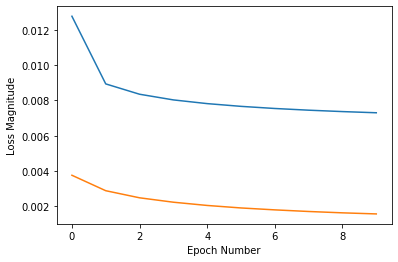

In [ ]:
Y_pred_c4 = model_comparison_4.predict(X_test)
mse_c4, mae_c4 = check_error_rates(Y_pred_c4, Y_test)
print("MSE:", mse_c4, "MAE:", mae_c4)

plt.xlabel('Epoch Number')
plt.ylabel("Loss Magnitude")
plt.plot(history_comparison_4.history['loss'])
plt.plot(history_comparison_4.history['val_loss'])

In [ ]:
# Model with only one ReLu layer
# used for comparing the most simple model possible.
model_one_layer = models.Sequential()
model_one_layer.add(layers.Dense(27, input_dim=27, activation='relu'))

# Compile model
model_one_layer.compile(optimizer=tensorflow.keras.optimizers.SGD(learning_rate=0.0001), loss='mean_squared_error')
# Fit the model
history_one_layer = model_one_layer.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=5, batch_size=19, verbose=True)

Epoch 1/5
84833/84833 [==============================] - 103s 1ms/step - loss: 0.1635 - val_loss: 0.0442
Epoch 2/5
84833/84833 [==============================] - 102s 1ms/step - loss: 0.0430 - val_loss: 0.0200
Epoch 3/5
84833/84833 [==============================] - 103s 1ms/step - loss: 0.0236 - val_loss: 0.0117
Epoch 4/5
84833/84833 [==============================] - 100s 1ms/step - loss: 0.0161 - val_loss: 0.0078
Epoch 5/5
84833/84833 [==============================] - 102s 1ms/step - loss: 0.0125 - val_loss: 0.0057


In [ ]:
Y_pred_one_layer = model_one_layer.predict(X_test)
mse_one_layer, mae_one_layer = check_error_rates(Y_pred_one_layer, Y_test)
print("MSE:", mse_one_layer, "MAE:", mae_one_layer)

MSE: 0.0057249214 MAE: 0.031723298


In [ ]:
# Here you can see that the model we used earlier stops advancing with more epochs.
# Nothing to see here, the model does not perform better adter epoch 5.
model_with_10_epochs = models.Sequential()
model_with_10_epochs.add(layers.Dense(27, input_dim=27, activation='tanh'))
model_with_10_epochs.add(layers.Dense(14, activation='tanh'))
model_with_10_epochs.add(layers.Dense(7, activation='tanh'))
model_with_10_epochs.add(layers.Dense(1, activation='relu'))
# Compile model
model_with_10_epochs.compile(optimizer=tensorflow.keras.optimizers.SGD(learning_rate=0.0001), loss='mean_squared_error')
# Fit the model
model_with_10_epochs = model_with_10_epochs.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=10, batch_size=19, verbose=True)

Epoch 1/10
84833/84833 [==============================] - 111s 1ms/step - loss: 0.0097 - val_loss: 0.0011
Epoch 2/10
84833/84833 [==============================] - 144s 2ms/step - loss: 0.0068 - val_loss: 0.0011
Epoch 3/10
84833/84833 [==============================] - 187s 2ms/step - loss: 0.0067 - val_loss: 0.0011
Epoch 4/10
84833/84833 [==============================] - 196s 2ms/step - loss: 0.0067 - val_loss: 0.0011
Epoch 5/10
84833/84833 [==============================] - 336s 4ms/step - loss: 0.0067 - val_loss: 0.0011
Epoch 6/10
84833/84833 [==============================] - 465s 5ms/step - loss: 0.0067 - val_loss: 0.0011
Epoch 7/10
84833/84833 [==============================] - 479s 6ms/step - loss: 0.0067 - val_loss: 0.0011
Epoch 8/10
84833/84833 [==============================] - 13633s 161ms/step - loss: 0.0067 - val_loss: 0.0011
Epoch 9/10
84833/84833 [==============================] - 486s 6ms/step - loss: 0.0067 - val_loss: 0.0011
Epoch 10/10
84833/84833 [=================

In [ ]:
train_target_mean = df_train['TargetVariable'].mean()
df_check_prediction_with_mean = df_test.copy()
df_check_prediction_with_mean['TrainMean'] = train_target_mean
df_check_prediction_with_mean


mse_one_layer, mae_one_layer = check_error_rates(df_check_prediction_with_mean[['TrainMean']], df_check_prediction_with_mean[['TargetVariable']])
print("MSE:", mse_one_layer, "MAE:", mae_one_layer)

MSE: 0.001049609505571425 MAE: 0.016164006665349007
